<mark> <font size="3"> Suman Pan - 218352 </mark>


<mark> <font size="3"> Clara Llòria - 218147 </mark>

# Lab 5: Stereo Matching and Shape from Silhouette

This lab session is divided in two parts. In the first one, you will compute a disparity map from a pair of images.  A disparity map is an image that stores the inverse of the distance to the camera center of the points
seen at every pixel, i.e. the depth.  This will enable us, for example in case our cameras are calibrated, to display a dense cloud of points representing the scene.

To compute the disparity map with a local method, we will have to compute correspondences for every pixel in the reference image.  These are many more correspondences than the ones given by SIFT/SURF/ORB.  For every pixel in the first image, we will travel its corresponding epipolar line in the second image looking for its correspondence. Since the pair of images are stereo-rectified (parallel views) the epipolar lines are horizontal and the coordinates of the corresponding points differ just by a horizontal displacement, the disparity.  By comparing the information around a neighborhood of the pixels on both images we will decide whether the pixels do correspond to each other.

In the second part, you will compute a 3D reconstruction of an object given some binary images corresponding to different points of view. These binary images, called the silhouettes, contain a segmentation of the object of interest that we want to reconstruct.

In particular, the goal of this lab session is to learn the following concepts:

- How to compute disparity/depth maps from pairs of images.
- Compare different cost functions and window sizes.
- How to aggregate costs through bilateral weights.
- How to extract a Visual Hull from a set of different views.

In [1]:
import math
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt

C:\Users\pansu\anaconda3\lib\site-packages\numpy
C:\Users\pansu\anaconda3\lib\site-packages\cv2\data
C:\Users\pansu\OneDrive\Documentos\3_trim_4rto\Vision_3D\3D_Vision_labs\Lab5
C:\Users\pansu\.matplotlib
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\.matplotlib
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pansu\anaconda3\lib\site-packages\matplotlib\mpl-data
C:\Users\pan

## 1. Stereo matching

First we will work with a pair of stereo-recified images from the Middlebury stereo dataset: http://vision.middlebury.edu/stereo/. The ground truth disparity is available and it will be useful to validate the code to be completed and it will allow us to measure errors as well.

The incomple function `stereo_computation` is provided; you have to complete it with the SSD cost, the NCC similarity measure and the bilateral weights. 

**Q1.** Complete the `stereo_computation` function with the computation of the SSD cost.

**Q2.** Execute cell code given after the `stereo_computation` function. This code estimates the disparity between a pair of stereo rectified images. How do the error in the estimation and the occluded areas are related?

**Q3.** Compute the global error.

**Q4.** Evaluate the results changing the window size (e.g. 5$\times$5, 9$\times$9, 21$\times$21). Comment the results and the differences among the different results.

**Q5.** Complete the `stereo_computation` function with the computation of the NCC cost.

**Q6.** Compare the results with those obtained with the SDD cost.

**Q7.** Complete the `stereo_computation` function with the bilateral weights. Suggested parameters: $\gamma_{col}=12$ and `math.floor(win_size/2)` for $\gamma_{pos}$.

**Q8.** Evaluate the results changing the window size (e.g. 5 $\times$ 5, 9 $\times$ 9, 21 $\times$ 21) and compare to the previous case that uses uniform weights (SDD cost).


ANSWERS:

Q2:How do the error in the estimation and the occluded areas are related?
If we cannot find the apropiate correspondence because the pixel is occluded, we can take wrong disparity value, therefore there will be a error in the estimation of the stereo computation.

Q4:Evaluetate the results changing the window size (e.g. 5 × 5, 9 × 9, 21 × 21)
Comment the results and the differences among the different results.


Q6:Compare the results with those obtained with the SDD cost and NCC cost


Q8:Evaluate the results changing the window size (e.g. 5  ×  5, 9  ×  9, 21  ×  21) and compare to the previous case that uses uniform weights (SDD cost).

In [2]:
# bilateral weigths
def get_bilateral_weights( win_img, win_size):

    
    gamma_col,gamma_pos = 12, math.floor(win_size/2)
    h, w, channels = np.shape(win_img)
    weights=np.zeros([h,w,channels])
    p = math.floor(h/2),math.floor(w/2)
    for i in range(h):
        for j in range(w):
            q = i,j

            delta_c=(1/3)*(np.abs( win_img[p]- win_img[q] )).sum()

            delta_g= np.sqrt((p[0]-q[0])**2+(p[1]-q[1])**2)#np.linalg.norm(p-q)#eucliden dist

            w_col =- delta_c/gamma_col
            w_pos =- delta_g/gamma_pos

            weights[i,j] = np.exp(-(w_col+w_pos))
    

    return weights


In [4]:
def stereo_computation(color_left_img, color_right_img, min_disparity, max_disparity, win_size, bilateral_weights=False, method='ssd'):
    """
    -left image
    -right image
    -minimum disparity
    -maximum disparity
    -window size
    -bilateral_weights
    -matching cost
    """
    
    # conversion to float images to make calculations
    color_left_img = color_left_img.astype(np.float32)
    color_right_img = color_right_img.astype(np.float32)
    height, width, channel = np.shape(color_left_img)
#     print(height,width)
    
    #cambiar
    win_step = int(win_size/2)
#     print(win_step)

    disparity = np.zeros([height,width])
    err_cost=np.zeros(max_disparity)
    disp_map = np.zeros(max_disparity)

    w = 1 
#     count = 0
    # iterate over the image
    for i in range(win_step, height-win_step):
        for j in range(win_step, width-win_step):

            # for every pixel in the left image, as the template            
            win_1 = color_left_img[i-win_step:i+win_step+1, j-win_step:j+win_step+1]
            
            # para cada uno de los pixels de la img
            if bilateral_weights:
                p_interest = i,j
                w = get_bilateral_weights(win_1, win_size)
                
            
            min_d = -min(max_disparity,j-win_step) # j=2, 16,j
            max_d = min(width-j-win_step, max_disparity)
#             print(min_d)
#             print(max_d)
            for d in range(min_d,max_d):
                
#                 count += 1
                # search the one that has min matching cost
#                     if (color_right_img[i-win_step:i+win_step+1, j-win_step+d:j+win_step+d+1].shape == (9,9,3)):
                win_2 = color_right_img[i-win_step:i+win_step+1, j-win_step+d:j+win_step+d+1]
                        #central pixel
#                     else:
#                         break

                if method=='ssd':
                    err_cost[d] = (w * (win_1 - win_2)**2).sum()

                elif method=='ncc': 
                    win1_bar = (w * win_1).sum()
                    win2_bar = (w * win_2).sum()
                    numerator = (w * (win_1 - win1_bar) * (win_2 - win2_bar)).sum()
                    sigma_I1 = np.sqrt((w * (win_1 - win1_bar)**2).sum())
                    sigma_I2 = np.sqrt((w * (win_2 - win2_bar)**2).sum())
                    err_cost[d] = numerator / (sigma_I1 * sigma_I2)

                else:
                    raise(NameError)
                
            min_index = np.argmin(err_cost)
            min_err = np.min(err_cost)
            
            disparity[i,j]= min_index
#             print(min_index)
#         break
                
  
    return disparity


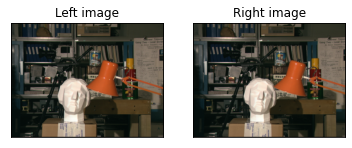

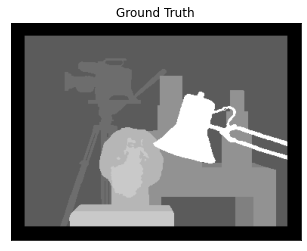

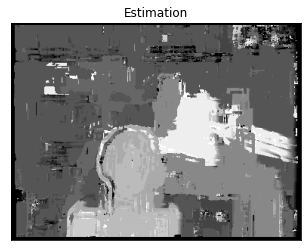

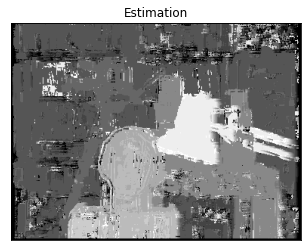

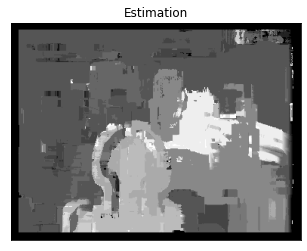

In [7]:
# Data images (rectified images)
img1 = cv2.imread('./data1/scene1.row3.col3.ppm') 
img2 = cv2.imread('./data1/scene1.row3.col2.ppm') 
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) 
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) 
 
plt.subplot(1,2,1),plt.imshow(img1) 
plt.title('Left image') 
plt.xticks([]),plt.yticks([]) 
plt.subplot(1,2,2),plt.imshow(img2) 
plt.title('Right image') 
plt.xticks([]),plt.yticks([]) 
plt.show() 
 
# Disparity ground truth image 
img_gt = cv2.imread('./data1/truedisp.row3.col3.pgm', cv2.IMREAD_GRAYSCALE) 
plt.imshow(img_gt,'gray') 
plt.xticks([]),plt.yticks([]) 
plt.title("Ground Truth") 
plt.show() 
 
def plot_stereo_function(img1,img2):    
    # Set minimum and maximum disparity 
    min_disparity = 0 
    max_disparity = 16

    # Set window (patch) size
    w_size = [9,5 ,21]
    ssd_disp = np.zeros(shape=(img1.shape[0], img1.shape[1]))

    for w in range(len(w_size)):
        w_size_current = w_size[w]
        ssd_disp = stereo_computation(img1, img2, min_disparity, max_disparity,
                                      w_size_current, bilateral_weights=True, method='ssd')

        #Display the error image with respect to the ground truth\n
        plt.imshow(ssd_disp,'gray')
        plt.xticks([]),plt.yticks([])
        plt.title("Estimation")
        plt.show() 
plot_stereo_function(img1,img2)

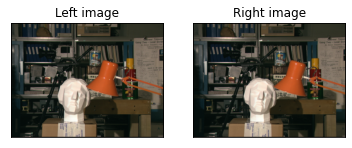

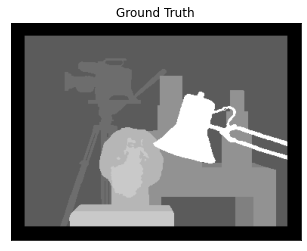

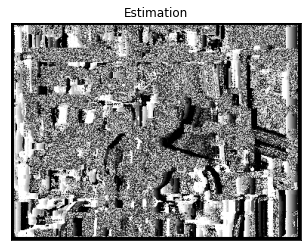

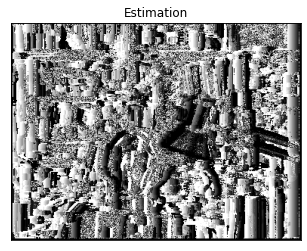

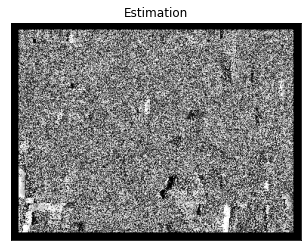

In [8]:
# Data images (rectified images)
img1 = cv2.imread('./data1/scene1.row3.col3.ppm') 
img2 = cv2.imread('./data1/scene1.row3.col2.ppm') 
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) 
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) 
 
plt.subplot(1,2,1),plt.imshow(img1) 
plt.title('Left image') 
plt.xticks([]),plt.yticks([]) 
plt.subplot(1,2,2),plt.imshow(img2) 
plt.title('Right image') 
plt.xticks([]),plt.yticks([]) 
plt.show() 
 
# Disparity ground truth image 
img_gt = cv2.imread('./data1/truedisp.row3.col3.pgm', cv2.IMREAD_GRAYSCALE) 
plt.imshow(img_gt,'gray') 
plt.xticks([]),plt.yticks([]) 
plt.title("Ground Truth") 
plt.show() 
 
def plot_stereo_function(img1,img2):    
    # Set minimum and maximum disparity 
    min_disparity = 0 
    max_disparity = 16

    # Set window (patch) size
    w_size = [9,5 ,21]
    ssd_disp = np.zeros(shape=(img1.shape[0], img1.shape[1]))

    for w in range(len(w_size)):
        w_size_current = w_size[w]
        ssd_disp = stereo_computation(img1, img2, min_disparity, max_disparity,
                                      w_size_current, bilateral_weights=True, method='ncc')

        #Display the error image with respect to the ground truth\n
        plt.imshow(ssd_disp,'gray')
        plt.xticks([]),plt.yticks([])
        plt.title("Estimation")
        plt.show() 
plot_stereo_function(img1,img2)

Once the code is completed and you finish the experiments with the Middlebury image, the next step is to apply the code to our lab 4 images. These images are not rectified, we have rectified them by applying a proper homography to each one of them. The stereo-rectified images are the ones provided in this lab. The lab images are big. To speed up the computations, you can scale-down the images by a factor of 0.25. Once everything is working properly, you can increase the scale in order to get higher resolution results.

**Q9.** Set proper values for the disparity limits.

**Q10.** Comment the result obtained. Why do you think the disparity is not well estimated
in some parts of the image?

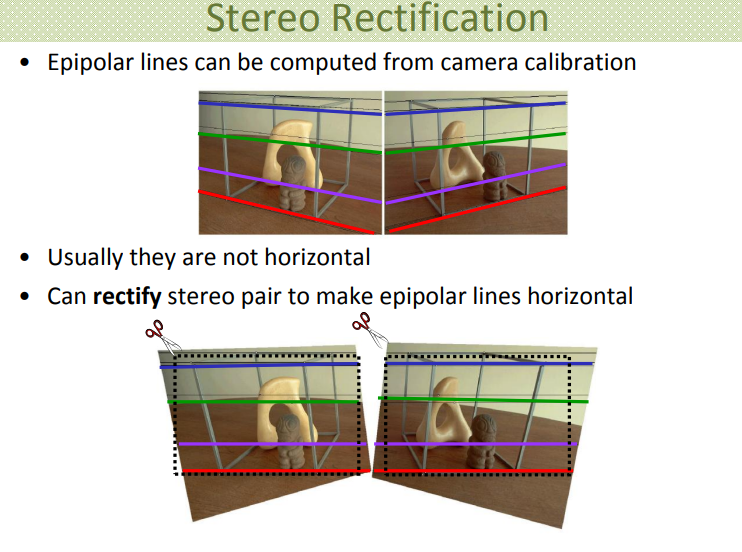

In [ ]:
img1 = cv2.imread('./data1/rectif0.png')
img2 = cv2.imread('./data1/rectif1.png'),
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

scale_percent = 15 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
img1 = cv2.resize(img1, dim)
img2 = cv2.resize(img2, dim)

plot_stereo_function(img1,img2)

Para poder utilizar este metodo, la imgen tiene que ser rectificada.

## 2. Shape from silhouette: visual hull method

The Visual Hull is a 3D reconstruction technique that allows to recover a 3D shape given its silhouettes in different views. A silhouette is a mask that provides a segmentation of the foreground object. The Visual Hull may be obtained as the intersection of the visual cones of the different points of view, which are generated by backprojection of the silhouttes using camera parameters. The advantage of this method is that it is very simple, it is non-iterative and can be easily parallelized. Its main disadvantage is the inability to obtain the exact shape of the object (e.g. cavities in the object cannot be recovered) but it is widely used with multi-view stereo algorithms, either as a first step or in conjunction with the multi-view reconstruction providing additional constraints.
In practice, the visual cones are not estimated, instead, a voxel grid is defined and all the voxels of the grid are projected onto each image ir order to check if the voxel projects inside the object silhouette or not.

In order to visualize the 3D volume we will use the Python library IPyvolume: https://ipyvolume.readthedocs.io/en/latest/ 

You will have to install the library, more information here: https://ipyvolume.readthedocs.io/en/latest/install.html

In our case it worked with the following commands:

- `pip install ipyvolume`
 
- `jupyter nbextension enable --py --sys-prefix ipyvolume` 
 
- `jupyter nbextension enable --py --sys-prefix widgetsnbextension`

In [ ]:
!pip install ipyvolume

!jupyter nbextension enable --py --sys-prefix ipyvolume

!jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [ ]:
import ipyvolume as ipv

# Shape from silhouette - Visual Hull algorithm

# Define variables
bbox = np.array([[0.2, -0.3, -1.8],[2.2, 1.3, 2.7]]) # [minX minY minZ; maxX maxY maxZ]
volumeX = 40 # 64 # start with a small volume and once code works properly you can increase its size
volumeY = 40 # 64
volumeZ = 80 # 128
volumeThreshold = 17
silhouetteThreshold = 100
numCameras = 18


# Load silhouette images and projection matrices
images = []
Ps = []
for i in range(numCameras):
    
    P = np.loadtxt("data2/david_{:02d}.pa".format(i), delimiter=' ')
    Ps.append(P)
    
    m = cv2.imread("data2/david_{:02d}.jpg".format(i),cv2.IMREAD_GRAYSCALE)
    ret,sil = cv2.threshold(m,silhouetteThreshold,255,cv2.THRESH_BINARY)
    images.append(sil)
    
    plt.subplot(1,2,1),plt.imshow(m,'gray',vmin=0,vmax=255)
    plt.title('image')
    plt.xticks([]),plt.yticks([])
    plt.subplot(1,2,2),plt.imshow(sil,'gray',vmin=0,vmax=255)
    plt.title('silhouette')
    plt.xticks([]),plt.yticks([])
    plt.show()

T = np.identity(4)
T[:3,3] = bbox[0,:]
T = T @ np.diag([(bbox[1,0]-bbox[0,0])/volumeX, (bbox[1,1]-bbox[0,1])/volumeY, (bbox[1,2]-bbox[0,2])/volumeZ, 1])

F = np.array([[1, 0, 0, 0],[0, 0, 1, 0],[0, -1, 0, 0],[0, 0, 0, 1]]) # flip y and z axes for better display in isosurface
T = F @ T

Execute the code in the cell above.

**Q11.** How are the silhouettes extracted in the provided code? Would it work in a general case? Why?

Execute the following cell code.

Usan mapas para detectar la estructura.


Fails in case of incomplete (inconsistent) silhouettes.
Visual hull methods do not recover concavities. 


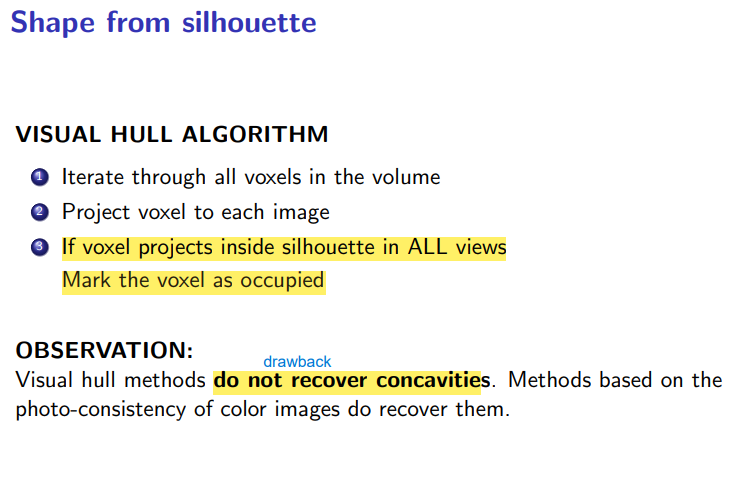

In [ ]:
from PIL import Image, ImageDraw

# Draw projection of volume corners
for i in range(numCameras):

    corners = np.array([[0, 0, 0, 1],[0, 0, volumeZ, 1],[0, volumeY, 0, 1], [0, volumeY, volumeZ, 1], [volumeX, 0, 0, 1], [volumeX, 0, volumeZ, 1], [volumeX, volumeY, 0, 1], [volumeX, volumeY, volumeZ, 1]])
    corners = corners.T
    pcorners = Ps[i] @ T @ corners
    pcorners = pcorners / pcorners[2][np.newaxis]
    
    img_path = "data2/david_{:02d}.jpg".format(i)
    I = Image.open(img_path)
    plt.figure()
    canv2 = ImageDraw.Draw(I)
    for i in range(8):
        canv2.ellipse((pcorners[0,i], pcorners[1,i], pcorners[0,i]+7, pcorners[1,i]+7), fill = 'yellow', outline ='yellow')
    plt.xticks([]),plt.yticks([])
    plt.imshow(I)


**Q12.** In your opinion, what is the projection of volume corners useful for.

The following cell contains the visual hull algorithm with a missing part that needs to be completed.

**Q13.** Complete the missing part of the code and execute the final cell to visualize the 3D reconstruction.

In [ ]:
Q12:

Q13:



In [ ]:
# Visual Hull computation

# PAGS 11-13 TEORIA 9
volume = np.zeros((volumeX,volumeY,volumeZ))

x = np.arange(0.5, volumeX, 1)
y = np.arange(0.5, volumeY, 1)
z = np.arange(0.5, volumeZ, 1)
voxel3Dx, voxel3Dy, voxel3Dz = np.meshgrid(x, y, z)
# print(voxel3Dx.shape,voxel3Dy.shape,voxel3Dz.shape)
ny, nx = images[0].shape
    
for n in range(numCameras):
    for x in range(volumeX):
        for y in range(volumeY):
            for z in range(volumeZ):
                voxel = np.array([voxel3Dx[x,y,z], voxel3Dy[x,y,z], voxel3Dz[x,y,z], 1])
                world_coords = T @ voxel.T
#                 print(np.shape(world_coords))
                # complete ...
#                 world_coords = [world_coords[0], world_coords[2],world_coords[1], world_coords[3]]
                image_pixel = np.dot(Ps[n], world_coords)
                image_pixel /= image_pixel[2]
                
#                 image_pixel = int(image_pixel)
#                 print(image_pixel)
                curr_image = images[n]
#                 print(np.shape(curr_image))
#                 print(image_pixel)
                x_img=int(image_pixel[0])-1
                y_img = int(image_pixel[1]) - 1

                if y_img <= nx or x_img <= ny:
                    value = curr_image[y_img ,x_img]
                    if value == 255:
                        volume[x,y,z] += 1 
#                 else:
#                     print(image_pixel)
                
                #print(value)
#                 images[]

In [ ]:
ipv.figure()
ipv.plot_isosurface(volume, level=volumeThreshold, color='gray', extent=[[0.2, 2.2], [-0.3, 1.3], [-1.8, 2.7]])
ipv.squarelim()
ipv.show()